# Langmuir Probe

Data analysis of the langmuir probe experiment.

Data is obtained

First, we import all the necessary modules

In [1]:
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit

import matplotlib.axes as axes
import matplotlib.pyplot as plt
# from google.colab import files


import pandas as pd
import glob
import os

import scipy


In [2]:
# -------------------------------------------------
# Matplotlib settings for thicker lines & bigger fonts
# -------------------------------------------------
plt.rcParams.update({
    'font.size': 18,          # Default text size
    'axes.labelsize': 18,     # Axis label size
    'axes.titlesize': 20,
    'legend.fontsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'lines.linewidth': 5,     # Thicker lines by default
    'lines.markersize': 9,
    'axes.linewidth': 2,
    'xtick.major.size': 10,
    'xtick.major.width': 2,
    'ytick.major.size': 10,
    'ytick.major.width': 2,
    'xtick.minor.size': 5,
    'xtick.minor.width': 1,
    'ytick.minor.size': 5,
    'ytick.minor.width': 1
})


Now we define a custom function to load the data from the .txt files labview outputs

In [3]:
def load_langmuir_data(file_path):
    """
    Load plasma data from file, extracting only the first section with 5 columns.

    Parameters:
    -----------
    file_path : str
        Path to the data file

    Returns:
    --------
    pandas.DataFrame
        DataFrame containing the 5 columns of data
    """
    # Read file line by line
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Find the first empty line
    empty_line_index = -1
    for i, line in enumerate(lines):
        if line.strip() == '':
            empty_line_index = i
            break

    # Handle case where no empty line was found
    if empty_line_index == -1:
        print("Warning: No empty line found. Using all lines in the file.")
        data_lines = lines
    else:
        data_lines = lines[:empty_line_index]

    # Parse the data
    data = []
    skipped_lines = 0

    # Try to detect if we need to handle different line formats
    if len(data_lines) > 0:
        sample_line = data_lines[0].strip()
        if sample_line.endswith(','):
            print("Detected lines ending with commas. Will remove trailing commas.")
        else:
            print("Lines do not end with commas.")

    for line in data_lines:
        # Remove trailing comma if present
        clean_line = line.rstrip(',\r\n')
        # Split by comma
        values = clean_line.split(',')

        # Filter out empty strings and convert to float
        # If there's an empty value, replace with NaN
        float_values = []
        for val in values:
            if val.strip():  # Check if the value is not just whitespace
                float_values.append(float(val))
            else:
                float_values.append(float('nan'))

        # Only take the first 5 columns (pad with NaN if fewer than 5)
        while len(float_values) < 5:
            float_values.append(float('nan'))

        # Skip lines that would cause problems (all NaN or empty)
        if not all(np.isnan(val) for val in float_values[:5]):
            data.append(float_values[:5])
        else:
            skipped_lines += 1

    # Create DataFrame
    df = pd.DataFrame(data, columns=[
        'Voltage (V)',  # Based on the first column values
        'Current (A)',  # Small values in scientific notation
        'Unknown1',     # Large values with scientific notation
        'Unknown2',     # Values around 4130-4190
        'Unknown3'      # Constant values at 21508
    ])

    if skipped_lines > 0:
        print(f"Warning: Skipped {skipped_lines} lines that were empty or could not be parsed.")

    return df

In [5]:
DATA_DIRECTORY = "/Users/jorgegarciaponce/Desktop/Classes/Senior Spring/Physics 191/Plasma/athalia and jorge's data/langmuir2.0"


neg_files = glob.glob(os.path.join(DATA_DIRECTORY, "*.txt"))

# Load each file into a DataFrame and store in a dictionary
dataframes = {}
for file in neg_files:
    try:
        df = load_langmuir_data(file)
        dataframes[os.path.basename(file)] = df
    except Exception as e:
        print(f"Skipping {os.path.basename(file)}: {e}")
        continue


Detected lines ending with commas. Will remove trailing commas.
Detected lines ending with commas. Will remove trailing commas.
Detected lines ending with commas. Will remove trailing commas.
Detected lines ending with commas. Will remove trailing commas.
Detected lines ending with commas. Will remove trailing commas.
Detected lines ending with commas. Will remove trailing commas.
Detected lines ending with commas. Will remove trailing commas.
Detected lines ending with commas. Will remove trailing commas.
Detected lines ending with commas. Will remove trailing commas.
Detected lines ending with commas. Will remove trailing commas.
Detected lines ending with commas. Will remove trailing commas.
Detected lines ending with commas. Will remove trailing commas.
Detected lines ending with commas. Will remove trailing commas.
Detected lines ending with commas. Will remove trailing commas.
Detected lines ending with commas. Will remove trailing commas.
Detected lines ending with commas. Will 

First, we explore our data

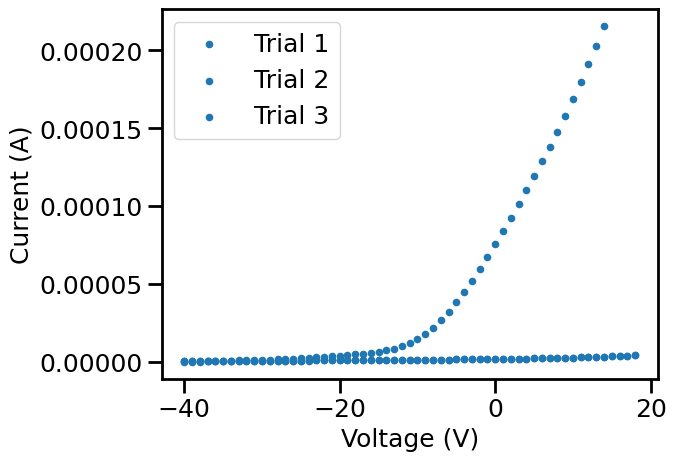

In [6]:
pressure = 366.8
voltage = 600
trial = 1

# Create a figure and axis
fig, ax = plt.subplots()

# Loop through the trials and plot them on the same axis
for trial in range(1, 4):   
    data = dataframes[f'{pressure}_{voltage}_-40_20_{trial}.txt']
    data.plot(x='Voltage (V)', y='Current (A)', kind='scatter', ax=ax, label=f'Trial {trial}')

# Show the plot
plt.show()

In [7]:
voltages = [400, 800, 1000, 1200, 1400, 1600, 1800, 2000]
trials = [1,2,3]
pressure = 366.8

processed_data = {}

for voltage in voltages:

    # Collect the data
    dfs = []
    for trial in range(1, 4):   
        data = dataframes[f'{pressure}_{voltage}_-40_20_{trial}.txt']
        dfs.append(data)
    
    # Merge the dataframes on 'Voltage (V)' to align x-values
    merged_df = pd.concat(dfs).groupby('Voltage (V)').agg({'Current (A)': ['mean', 'std']}).reset_index()

    # Flatten column names to avoid multi-index issues
    merged_df.columns = ['Voltage (V)', 'Mean Current (A)', 'Std Current (A)']

    # Extract values in a simple structure
    x = merged_df['Voltage (V)'].values  # Numpy array for direct indexing
    y_mean = merged_df['Mean Current (A)'].values
    y_std = merged_df['Std Current (A)'].values


    processed_data[f'{pressure}_{voltage}'] = (x, y_mean, y_std)




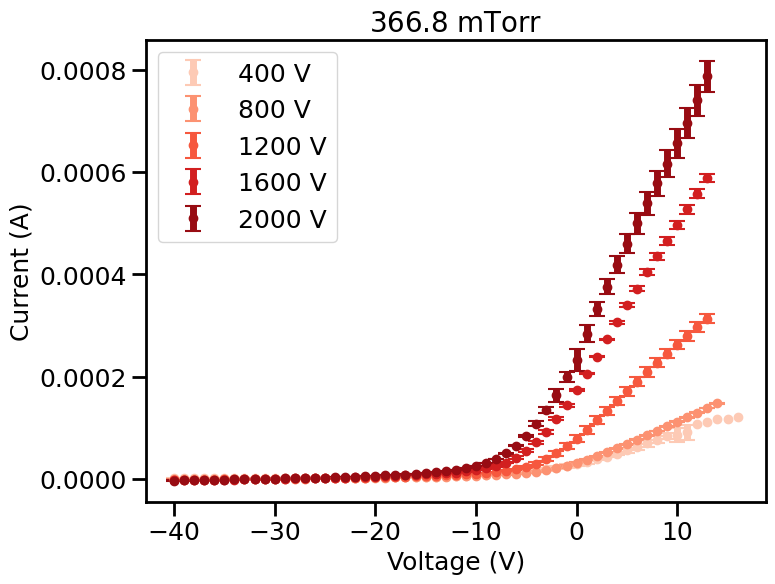

In [29]:
voltages = [400, 800,1200, 1600,2000]
trials = [1,2,3]
pressure = 366.8

plt.figure(figsize=(8, 6))

colors = plt.cm.Reds(np.linspace(0.2, 0.9, len(voltages)))  # Change 'viridis' to other colormaps if needed


for i, voltage in enumerate(voltages):

    x,y, err = processed_data[f'{pressure}_{voltage}']

    plt.errorbar(x, y, yerr=err, fmt='o', capsize=6, capthick=1.5, markersize=6, color=colors[i], label=f'{voltage} V')


plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')
plt.title(f'${pressure}$ mTorr')

plt.legend()
plt.show()


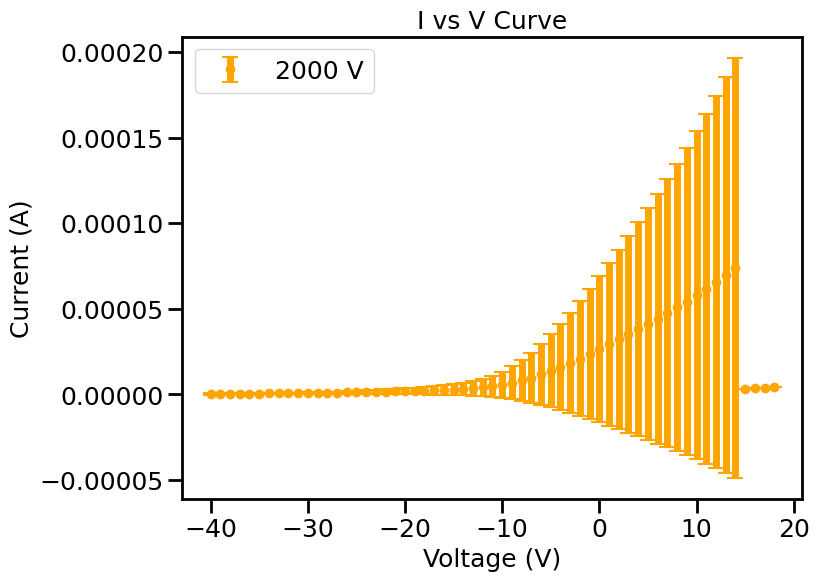

In [49]:



# Collect the data
dfs = []
for trial in range(1, 4):   
    data = dataframes[f'{pressure}_{600}_-40_20_{trial}.txt']
    dfs.append(data)

# Merge the dataframes on 'Voltage (V)' to align x-values
merged_df = pd.concat(dfs).groupby('Voltage (V)').agg({'Current (A)': ['mean', 'std']}).reset_index()

# Extract relevant values
x = merged_df['Voltage (V)']
y_mean = merged_df[('Current (A)', 'mean')]
y_std = merged_df[('Current (A)', 'std')]


plt.figure(figsize=(8, 6))

plt.errorbar(x, y_mean, yerr=y_std, fmt='o', capsize=6, capthick=1.5, markersize=6, color='orange', label=f'{voltage} V')


plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')
plt.title('I vs V Curve')

plt.legend()
plt.show()


In [22]:
merged_df

Voltage (V)   Current (A)              
                        mean           std
0        -40.0 -2.731221e-06  2.035131e-07
1        -39.0 -2.501681e-06  2.055142e-07
2        -38.0 -2.280219e-06  2.066749e-07
3        -37.0 -2.057053e-06  2.077814e-07
4        -36.0 -1.830370e-06  2.086272e-07
5        -35.0 -1.596259e-06  2.090719e-07
6        -34.0 -1.352588e-06  2.094604e-07
7        -33.0 -1.095744e-06  2.106190e-07
8        -32.0 -8.253258e-07  2.112142e-07
9        -31.0 -5.420125e-07  2.101798e-07
10       -30.0 -2.455580e-07  2.071063e-07
11       -29.0  6.622552e-08  2.071926e-07
12       -28.0  3.687123e-07  1.793304e-07
13       -27.0  6.738936e-07  1.660204e-07
14       -26.0  9.439717e-07  1.320064e-07
15       -25.0  1.184060e-06  1.497524e-07
16       -24.0  1.484434e-06  1.666702e-07
17       -23.0  1.840974e-06  1.911305e-07
18       -22.0  2.260665e-06  2.106664e-07
19       -21.0  2.741634e-06  2.254359e-07
20       -20.0  3.285267e-06  2.361001e-07
21       -19.0  3.888571e-06  2.416143e-07
22       -18.0  4.551766e-06  2.407839e-07
23       -17.0  5.271948e-06  2.340257e-07
24       -16.0  6.048588e-06  2.209553e-07
25       -15.0  6.871869e-06  2.021168e-07
26       -14.0  7.741080e-06  1.803380e-07
27       -13.0  8.668444e-06  1.733188e-07
28       -12.0  9.728006e-06  2.211756e-07
29       -11.0  1.107605e-05  3.399106e-07
30       -10.0  1.287698e-05  5.381320e-07
31        -9.0  1.526138e-05  7.588657e-07
32        -8.0  1.829799e-05  9.778423e-07
33        -7.0  2.226545e-05  1.418068e-06
34        -6.0  2.821268e-05  2.234689e-06
35        -5.0  3.702420e-05  3.170135e-06
36        -4.0  4.893781e-05  3.924565e-06
37        -3.0  6.372694e-05  4.376911e-06
38        -2.0  8.115915e-05  4.656860e-06
39        -1.0  1.020278e-04  5.875852e-06
40         0.0  1.260494e-04  4.300310e-06
41         1.0  1.504189e-04  4.143469e-06
42         2.0  1.759714e-04  3.792587e-06
43         3.0  2.023047e-04  3.316074e-06
44         4.0  2.277628e-04  4.435825e-06
45         5.0  2.553267e-04  1.998435e-06
46         6.0  2.816015e-04  1.148649e-06
47         7.0  3.072117e-04  8.337626e-07
48         8.0  3.321378e-04  8.168697e-07
49         9.0  3.563383e-04  9.952248e-07
50        10.0  3.800893e-04  1.128656e-06
51        11.0  4.032344e-04  1.293435e-06
52        12.0  4.258416e-04  1.434872e-06
53        13.0  4.482169e-04  1.806018e-06

In [12]:
dataframes[f'{pressure}_{voltage}_-40_20_{3}.txt']

,Voltage (V),Current (A),Unknown1,Unknown2,Unknown3
0,-40.0,-2.518434e-06,9.910000e+37,1938.857,21508.0
1,-39.0,-2.287628e-06,9.910000e+37,1939.919,21508.0
2,-38.0,-2.066048e-06,9.910000e+37,1940.980,21508.0
3,-37.0,-1.842938e-06,9.910000e+37,1942.040,21508.0
4,-36.0,-1.616221e-06,9.910000e+37,1943.101,21508.0
5,-35.0,-1.382655e-06,9.910000e+37,1944.160,21508.0
6,-34.0,-1.139448e-06,9.910000e+37,1945.222,21508.0
7,-33.0,-8.823438e-07,9.910000e+37,1947.336,21508.0
8,-32.0,-6.131568e-07,9.910000e+37,1948.422,21508.0
9,-31.0,-3.327079e-07,9.910000e+37,1949.481,21508.0
